# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = Summary()

## Get the data and choose the model

In [3]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

In [4]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=10)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=1000))

In [50]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_SYMBOL', 'VEP_VARIANT_CLASS', 'gene_type'],

    'freq': ['frequency_in_normals'],

    'database': ['VEP_COSMIC_CNT', 'VEP_in_dbSNP',
                 'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'Kaviar_AF'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = []
        
    for key, group in features_groups.items():
        if not key in groups_to_remove:
            final_selection += group
    
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove unique values
    return list(set(final_selection))

In [51]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)

X, y = data.get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (194211, 84) | y: (194211,)


,count_,freq_
False,187012,96.3%
True,7199,3.7%


## All features

In [9]:
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])

Run model... done! (484.95s)


In [10]:
metrics.print_mean()

▴ Mean accuracy         : 0.879 ± 0.002
▴ Mean f1               : 0.327 ± 0.006
▴ Mean roc_auc          : 0.912 ± 0.006
▴ Mean average_precision: 0.606 ± 0.014
▴ Mean recall           : 0.790 ± 0.016


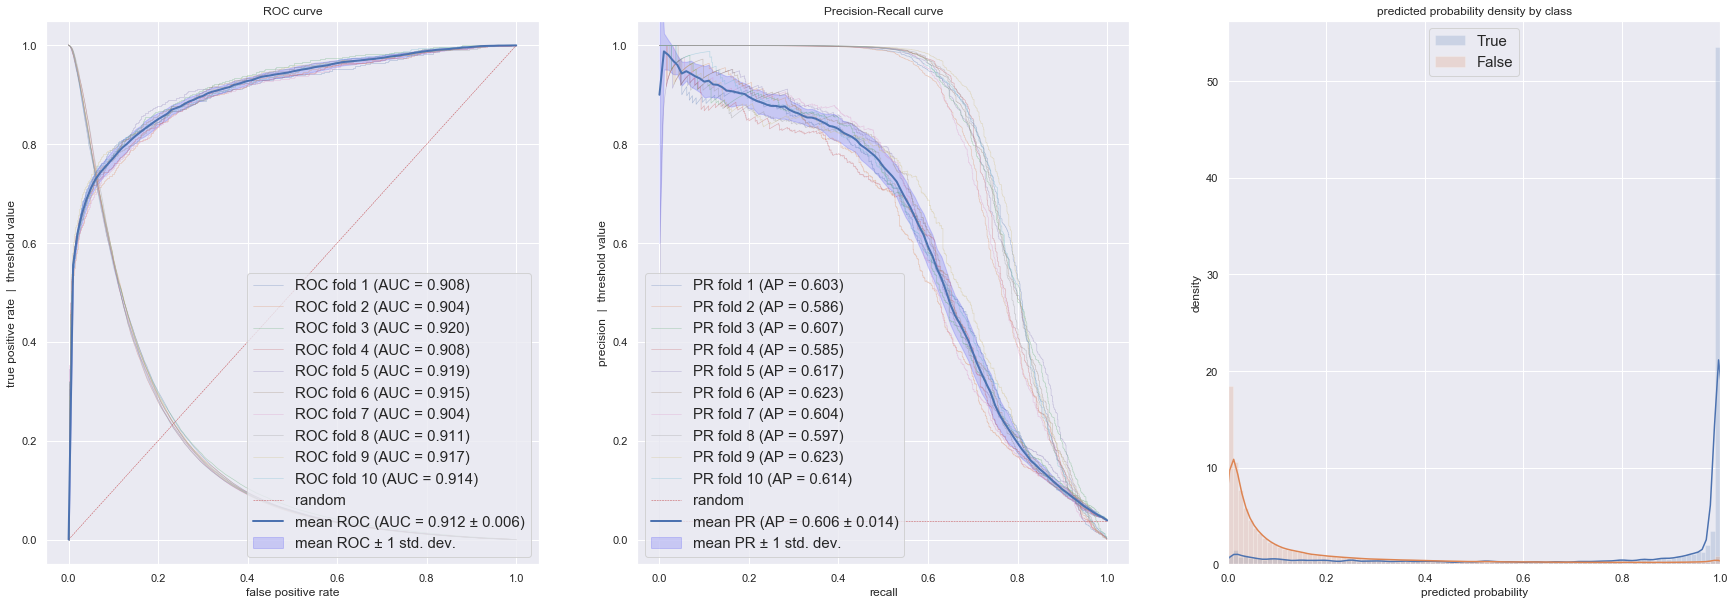

In [12]:
metrics.plot_threshold_decision_curves()

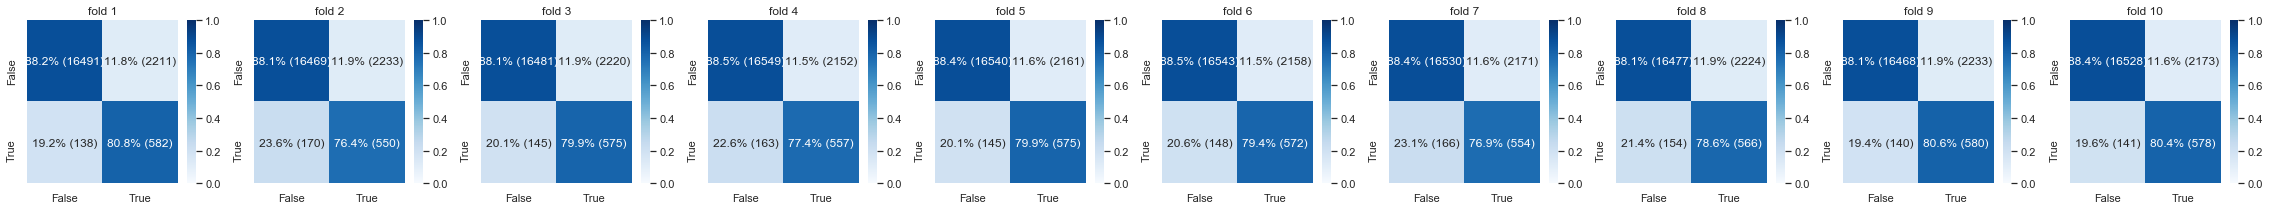

In [21]:
metrics.plot_confusion_matrix(figsize=(40, 3))

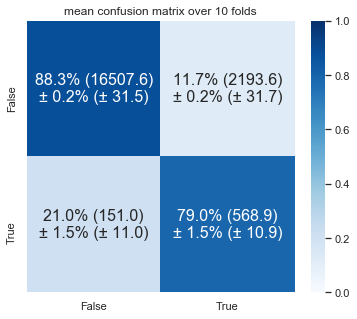

In [18]:
metrics.plot_mean_confusion_matrix(figsize=(6, 5), legend_size=16)

## Evaluation by groups

In [ ]:
summary = Summary()

In [43]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      GaussianNB())

In [ ]:
metrics_list = []

for group in features_groups.keys():
    print_md('**Withoug *{}* group** ({} features)'.format(group, len(features)))
    features = get_features(groups_to_remove = [group], individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
    
    print('Get X and y...', end= '')
    start = time.time()
    data.process(features)
    X, y = data.get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} features after processing)'.format(time.time() - start, X.shape[1]))
    
    metrics_list.append(Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall']))

**Withoug *NGS* group** (28 features)

Get X and y... done! (7.73s, 73 features)
Run model... done! (26.05s)


**Withoug *genome* group** (18 features)

Get X and y... done! (6.31s, 52 features)
Run model... done! (19.39s)


**Withoug *freq* group** (26 features)

Get X and y... done! (8.76s, 83 features)
Run model... done! (26.47s)


**Withoug *database* group** (28 features)

Get X and y... done! (6.56s, 71 features)
Run model... done! (22.53s)


**Withoug *consequence* group** (24 features)

Get X and y... done! (5.16s, 61 features)
Run model...

In [ ]:
for i, color in enumerate(['firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(metrics_list[i], 'RidgeRegression_unified_sampling_{}'.format(i), color)

In [ ]:
summary.display()
summary.plot()